# setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
# from ACSPaper.Matching import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'metacardis_replications')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

# load data

In [3]:
from LabData.DataLoaders.MetabolonLoader import MetabolonLoader
# mld = MetabolonLoader().get_data()
# mld.metabolites.loc['100009007']

In [44]:
metacardis_dir = os.path.join('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_diabetes_path = os.path.join(metacardis_dir, 'dataframes', 'MetaCardis_DiabetesRelatedVar_KC_230521.csv')
metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'metabolon', 'ShortlistedMetabolonMetabolites_rawdata_MC_forSHAP_KC_200521.csv')
# os.listdir(os.path.join(metacardis_dir, 'metabolomics', 'metabolon'))
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0).replace({'nan': np.nan})
metacardis_metadata_path = os.path.join(metacardis_dir, 'metabolomics', 'metadata', 'hub.metadata_reduced.samples.v10.r')
metacardis_X = metacardis_X.merge(pd.read_csv(metacardis_metadata_path, sep='\t', index_col=0)[['PATGROUPFINAL_C', 'SMOKE']], 
                                  on='SampleID', how='left').replace({'Yes':1, 'No':0})
metacardis_diabetes = pd.read_csv(metacardis_diabetes_path, index_col=0).replace({'Yes':1, 'No':0})
metacardis_diabetes.index.names = ['SampleID']
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group', 'GENDER', 'PATGROUPFINAL_C', 'SMOKE']].join(metacardis_diabetes).copy()
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
metacardis_metabolomics = metacardis_metabolomics.rename(columns={k:k.replace('9999', 'X - ') for k in metacardis_metabolomics.columns})
metacardis_serum_metabolomics = metacardis_metabolomics.drop(['Status', 'MC_ID'], axis=1).groupby('ID').first()
# print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
# metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# # metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

IHD372     304
HC275      273
MMC269     215
UMCC222    203
Name: Group, dtype: int64

In [45]:
metacardis_serum_metabolomics.shape
metacardis_X_age_bmi['SMOKE'].value_counts()

0.0    864
1.0    125
Name: SMOKE, dtype: int64

# serum metabolome

In [123]:
serum_res = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures/metabolon/', 'circ_heatmap_df_MMC_no_HPN_DYS-DM.csv'), index_col=0)
serum_res

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100020427,-10.155976,2.549957,0.009726,0.000000,0.119565,0.000000
100004523,-9.490470,-0.012484,0.036805,0.200714,0.005265,0.141974
100004056,-8.740516,0.491537,0.049153,0.120917,0.000000,0.000000
100000096,-8.104182,-0.063893,0.000000,0.025331,0.022601,0.000000
100006361,-8.087391,1.072853,0.000325,0.006318,0.013639,0.000000
...,...,...,...,...,...,...
100009232,3.990272,-0.802307,0.002318,0.000000,0.000000,0.000000
100000445,5.226085,-0.476963,0.072204,0.114427,0.006118,0.000000
501,9.791267,-0.512215,0.000000,0.012121,0.001731,0.000000
1869,10.550857,-1.051021,0.005118,0.017169,0.027414,0.000000


In [124]:
metacardis_X_age_bmi.Group.value_counts()

IHD372     304
HC275      273
MMC269     215
UMCC222    203
Name: Group, dtype: int64

In [125]:
hc = metacardis_X_age_bmi[metacardis_X_age_bmi.Group == 'HC275'].index.tolist()
mmc = metacardis_X_age_bmi[metacardis_X_age_bmi.Group == 'MMC269'].index.tolist()
umcc = metacardis_X_age_bmi[metacardis_X_age_bmi.Group == 'UMCC222'].index.tolist()
ihd = metacardis_X_age_bmi[metacardis_X_age_bmi.Group == 'IHD372'].index.tolist()
acs = metacardis_X_age_bmi[metacardis_X_age_bmi.PATGROUPFINAL_C == '4'].index.tolist()
# hc_ihd_res = metacardis_serum_metabolomics.reindex(serum_res.index, axis=1).dropna(axis=1)\
#                                     .apply(lambda x: directed_mannwhitneyu(x.loc[hc], x.loc[ihd])).T
# mmc_ihd_res = metacardis_serum_metabolomics.reindex(serum_res.index, axis=1).dropna(axis=1)\
#                                     .apply(lambda x: directed_mannwhitneyu(x.loc[mmc], x.loc[ihd])).T
# hc_acs_res = metacardis_serum_metabolomics.reindex(serum_res.index, axis=1).dropna(axis=1)\
#                                     .apply(lambda x: directed_mannwhitneyu(x.loc[hc], x.loc[acs])).T
# mmc_acs_res = metacardis_serum_metabolomics.reindex(serum_res.index, axis=1).dropna(axis=1)\
#                                     .apply(lambda x: directed_mannwhitneyu(x.loc[mmc], x.loc[acs])).T
# hc_ihd_res = hc_ihd_res.join(serum_res['Healthy-ACS'])
# hc_ihd_res = hc_ihd_res.loc[(hc_ihd_res['Healthy-ACS'].abs() > 0)]
# hc_ihd_res = hc_ihd_res.loc[fdr_correction(hc_ihd_res[1], 0.1)[0]]

# mmc_ihd_res = mmc_ihd_res.join(serum_res['Healthy-ACS'])
# mmc_ihd_res = mmc_ihd_res.loc[(mmc_ihd_res['Healthy-ACS'].abs() > 0)]
# mmc_ihd_res = mmc_ihd_res.loc[fdr_correction(mmc_ihd_res[1], 0.1)[0]]

# hc_acs_res = hc_acs_res.join(serum_res['Healthy-ACS'])
# hc_acs_res = hc_acs_res.loc[(hc_acs_res['Healthy-ACS'].abs() > 0)]
# hc_acs_res = hc_acs_res.loc[fdr_correction(hc_acs_res[1], 0.1)[0]]

# mmc_acs_res = mmc_acs_res.join(serum_res['Healthy-ACS'])
# mmc_acs_res = mmc_acs_res.loc[(mmc_acs_res['Healthy-ACS'].abs() > 0)]
# mmc_acs_res = mmc_acs_res.loc[fdr_correction(mmc_acs_res[1], 0.1)[0]]

In [219]:
y = 'ACS sample'
data = metacardis_serum_metabolomics.join(metacardis_X_age_bmi).copy()
data['const'] = 1
data[y] = None

data.loc[umcc+mmc+hc, y] = 0 
data.loc[acs, y] = 1
data.dropna(subset=[y], inplace=True)
covariates = ['AGE', 'GENDER', 'BMI_C', 'SMOKE', 'DiabetesStatus', 'const']
use_covariates = True
cols = serum_res.index

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm_notebook(cols):
    if col not in data.columns:
        continue
    if covariates:
        try:
            log = Logit(data.loc[:, y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results = logit_results.dropna()
logit_results['directional pval'] = logit_results.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)
logit_results = logit_results.join(serum_res[['Healthy-ACS']])

fdr_01 = fdr_correction(logit_results['Logit pval'])[1]<0.1
print(logit_results.shape)
print(fdr_01.sum())

print(spearmanr(logit_results[fdr_01]['Healthy-ACS'], logit_results[fdr_01]['directional pval']))
print(confusion_matrix(logit_results[fdr_01]['Healthy-ACS']>0, logit_results[fdr_01]['directional pval']>0))
# logit_results

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(278, 7)
133
SpearmanrResult(correlation=0.3716958610909906, pvalue=1.0577373041936104e-05)
[[53 36]
 [16 28]]


Text(0, 0.5, 'Number of metabolites')

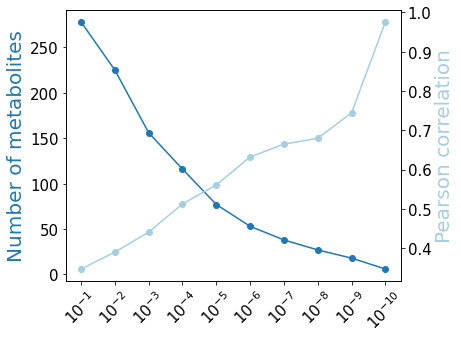

In [220]:
corrs = []
ns = []
replicated = []
temp_res = logit_results.copy()
bins = np.arange(1, 11, 1)
for i in bins:
    temp_res = temp_res.loc[(temp_res['Healthy-ACS'].abs() > i)]
    r, p = pearsonr(temp_res['directional pval'], temp_res['Healthy-ACS'])
#     r, p = spearmanr(temp_res['directional pval'], temp_res['Healthy-ACS'])
    replicated.append(((temp_res['directional pval']>0) == (temp_res['Healthy-ACS']>0)).sum() / temp_res.shape[0])
    corrs.append(r)
    ns.append(temp_res.shape[0])
    
colors = sns.color_palette('Paired', 6)[:]
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax2 = ax.twinx()
ax2.plot(bins, corrs, '-o', color=colors[0])
# ax2.plot(bins, replicated, '-o', color=colors[0])
ax.plot(bins, ns, '-o', color=colors[1])
# ax.set_yscale('log')
ax2.set_xlabel('P-value threshold for significance', fontsize=20)
ax.set_xticks(bins)
ax.set_xticklabels([r'$10^{-%0.1d}$'%(i) for i in ax.get_xticks()], rotation=45)
ax2.tick_params(labelsize=15)
ax.tick_params(labelsize=15)
ax2.set_ylabel('Pearson correlation', fontsize=20, color=colors[0])
ax.set_ylabel('Number of metabolites', fontsize=20, color=colors[1])


In [221]:
corrs

[0.3471080570883699,
 0.39002453293477357,
 0.4409711784155974,
 0.5127408565115195,
 0.5608939334891976,
 0.6321450587928283,
 0.664665174422727,
 0.6796099047362849,
 0.744438727315824,
 0.9754823888453127]

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='directional pval', ylabel='Healthy-ACS'>

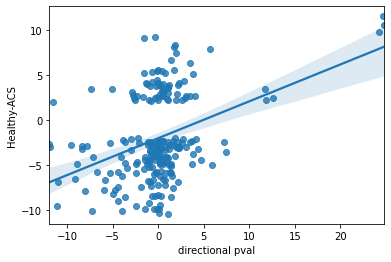

In [222]:
temp_res = logit_results.copy()
temp_res = temp_res.loc[(temp_res['Healthy-ACS'].abs() > 2)]
sns.regplot(temp_res['directional pval'], temp_res['Healthy-ACS'])

In [147]:
hc_acs_res
confusion_matrix(hc_acs_res['Healthy-ACS'] > 0, hc_acs_res[0] > 0)

array([[137, 125],
       [ 50,  91]])

# microbiome

In [138]:
mb_res = pd.read_csv(os.path.join('../', 'microbiome_pattern', 'logit_results_mmc_no_hpn+dys.csv'), index_col=0)
mb_res = mb_res.loc[(mb_res['Logit qval'] < 0.1)]
mb_res = mb_res.rename(columns={k:'PNP ' + k for k in mb_res.columns})
mb_res

,PNP Logit coef,PNP Logit pval,PNP Logit 0.025,PNP Logit 0.975,PNP Logit log,PNP Logit qval,PNP directional pval
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum|fSGB__3150|gSGB__10628|sSGB__17256,0.895352,0.001515,1.407893,4.257191,<statsmodels.discrete.discrete_model.BinaryRes...,0.071251,2.819691
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_sp_An62|fSGB__588|gSGB__1330|sSGB__1785,2.557321,0.000021,3.970811,41.916166,<statsmodels.discrete.discrete_model.BinaryRes...,0.005385,4.677076
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_synergistica|fSGB__588|gSGB__1330|sSGB__1786,1.705300,0.000070,2.374175,12.755342,<statsmodels.discrete.discrete_model.BinaryRes...,0.013463,4.154169
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter|s__Odoribacter_splanchnicus|fSGB__589|gSGB__1333|sSGB__1790,1.492759,0.000184,2.035241,9.726987,<statsmodels.discrete.discrete_model.BinaryRes...,0.020135,3.736311
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis|fSGB__599|gSGB__1409|sSGB__1934,1.352970,0.001489,1.679094,8.914552,<statsmodels.discrete.discrete_model.BinaryRes...,0.071251,2.827165
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_thermophilus|fSGB__1976|gSGB__5671|sSGB__8002,-1.101807,0.001571,0.167807,0.657920,<statsmodels.discrete.discrete_model.BinaryRes...,0.071251,-2.803712
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__unknown|fSGB__3052|gSGB__9578|sSGB__14992,-1.548211,0.000767,0.086285,0.523971,<statsmodels.discrete.discrete_model.BinaryRes...,0.053534,-3.115341
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp|fSGB__1451|gSGB__3628|sSGB__4914,-0.927535,0.001704,0.221586,0.706011,<statsmodels.discrete.discrete_model.BinaryRes...,0.071251,-2.768635
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__unknown|fSGB__1444|gSGB__3566|sSGB__4771,-1.632656,0.001997,0.069392,0.550281,<statsmodels.discrete.discrete_model.BinaryRes...,0.076666,-2.699730
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__unknown|fSGB__1445|gSGB__3572|sSGB__4780,-2.433121,0.000017,0.028985,0.265731,<statsmodels.discrete.discrete_model.BinaryRes...,0.005385,-4.776491


In [223]:
y = 'ACS sample'
data = metacardis_X.join(metacardis_X_age_bmi[['DiabetesStatus']]).copy()
data['const'] = 1
data[y] = None

data.loc[mmc+umcc+hc, y] = 0 
data.loc[acs, y] = 1
data.dropna(subset=[y], inplace=True)
covariates = ['AGE', 'GENDER', 'BMI_C', 'SMOKE', 'DiabetesStatus', 'const']
# covariates = ['const']
use_covariates = True
cols = mb_res.index
# cols = data.filter(regex='k__').columns
data.loc[:, cols] = data.loc[:, cols].apply(np.log10).values

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm_notebook(cols):
    if col not in data.columns:
        continue
    if covariates:
        try:
            log = Logit(data.loc[:, y].astype(float), 
                                    data.loc[:, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results = logit_results.dropna()
logit_results['directional pval'] = logit_results.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)
logit_results = logit_results.join(mb_res[['PNP directional pval']])

fdr_01 = fdr_correction(logit_results['Logit pval'])[1]<0.1
print(logit_results.shape)
print(fdr_01.sum())

print(spearmanr(logit_results[fdr_01]['PNP directional pval'], logit_results[fdr_01]['directional pval']))
print(confusion_matrix(logit_results[fdr_01]['PNP directional pval']>0, logit_results[fdr_01]['directional pval']>0))
logit_results

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(20, 7)
0
SpearmanrResult(correlation=nan, pvalue=nan)
[]


,Logit coef,Logit pval,Logit 0.025,Logit 0.975,Logit log,directional pval,PNP directional pval
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum|fSGB__3150|gSGB__10628|sSGB__17256,0.083267,0.749064,0.652506,1.81026,<statsmodels.discrete.discrete_model.BinaryRes...,0.125481,2.819691
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_sp_An62|fSGB__588|gSGB__1330|sSGB__1785,-0.00616979,0.984032,0.543143,1.81856,<statsmodels.discrete.discrete_model.BinaryRes...,-0.006991,4.677076
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Butyricimonas|s__Butyricimonas_synergistica|fSGB__588|gSGB__1330|sSGB__1786,-0.172998,0.57665,0.458249,1.54395,<statsmodels.discrete.discrete_model.BinaryRes...,-0.239087,4.154169
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter|s__Odoribacter_splanchnicus|fSGB__589|gSGB__1333|sSGB__1790,-0.259827,0.317733,0.463234,1.28386,<statsmodels.discrete.discrete_model.BinaryRes...,-0.497938,3.736311
k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis|fSGB__599|gSGB__1409|sSGB__1934,-0.0469504,0.81408,0.645163,1.41107,<statsmodels.discrete.discrete_model.BinaryRes...,-0.089333,2.827165
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_thermophilus|fSGB__1976|gSGB__5671|sSGB__8002,-0.211233,0.446113,0.470192,1.39396,<statsmodels.discrete.discrete_model.BinaryRes...,-0.350555,-2.803712
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__unknown|fSGB__3052|gSGB__9578|sSGB__14992,-0.499858,0.150324,0.30698,1.19872,<statsmodels.discrete.discrete_model.BinaryRes...,-0.822971,-3.115341
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp|fSGB__1451|gSGB__3628|sSGB__4914,0.247572,0.183544,0.889331,1.84491,<statsmodels.discrete.discrete_model.BinaryRes...,0.736259,-2.768635
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__unknown|fSGB__1444|gSGB__3566|sSGB__4771,0.463885,0.107359,0.90414,2.79698,<statsmodels.discrete.discrete_model.BinaryRes...,0.969163,-2.699730
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__unknown|fSGB__1445|gSGB__3572|sSGB__4780,-0.0548454,0.895679,0.417006,2.14892,<statsmodels.discrete.discrete_model.BinaryRes...,-0.047848,-4.776491


In [195]:
logit_results[fdr_correction(logit_results['Logit pval'], alpha=0.1)[0]]
# fdr_correction(logit_results['Logit pval'], alpha=0.1)[0]

,Logit coef,Logit pval,Logit 0.025,Logit 0.975,Logit log,directional pval,PNP directional pval
k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens|fSGB__2991|gSGB__9395|sSGB__14631,1.72884,0.000850486,2.04022,15.5586,<statsmodels.discrete.discrete_model.BinaryRes...,3.070333,NaN
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis|fSGB__1976|gSGB__5679|sSGB__8069,0.931395,4.09654e-05,1.62639,3.96072,<statsmodels.discrete.discrete_model.BinaryRes...,4.387583,NaN
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis|fSGB__1976|gSGB__5679|sSGB__8076,1.17942,1.64912e-07,2.09145,5.05807,<statsmodels.discrete.discrete_model.BinaryRes...,6.782747,NaN
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius|fSGB__1976|gSGB__5671|sSGB__8007,0.918652,4.76601e-05,1.60949,3.9016,<statsmodels.discrete.discrete_model.BinaryRes...,4.321845,NaN
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius|fSGB__1976|gSGB__5671|sSGB__8010,0.630108,0.000703609,1.30422,2.70366,<statsmodels.discrete.discrete_model.BinaryRes...,3.152669,NaN
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_7|fSGB__1442|gSGB__3552|sSGB__4749,-0.482146,3.51365e-05,0.491373,0.775893,<statsmodels.discrete.discrete_model.BinaryRes...,-4.454241,NaN
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712,-0.846376,1.0906e-06,0.305231,0.602864,<statsmodels.discrete.discrete_model.BinaryRes...,-5.962333,-2.975335
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ramulus|fSGB__1455|gSGB__3650|sSGB__4959,-0.737459,0.000222665,0.323365,0.707551,<statsmodels.discrete.discrete_model.BinaryRes...,-3.652349,NaN
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_sp|fSGB__1332|gSGB__3215|sSGB__4247,-0.591628,3.53704e-05,0.418114,0.732527,<statsmodels.discrete.discrete_model.BinaryRes...,-4.451360,NaN
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes|fSGB__1414|gSGB__3435|sSGB__4577,-0.610883,0.000122175,0.397507,0.741394,<statsmodels.discrete.discrete_model.BinaryRes...,-3.913019,NaN


In [187]:
# mb_hc_ihd_res[mb_hc_ihd_res[1] < 0.05]
# pearsonr(mb_hc_ihd_res[0], mb_hc_ihd_res['Logit coef'])
# mb_mmc_acs_res
# mb_hc_ihd_res
spearmanr(logit_results['PNP directional pval'], logit_results['directional pval'])

SpearmanrResult(correlation=0.31127819548872177, pvalue=0.1815757703703732)

# extract our data for MetaCardis models

In [9]:
metabolon_dir = os.path.join(paper_dir, 'serum_metabolomics_signatures/')

pnp_data_metabolon = pd.read_csv(os.path.join(metabolon_dir, 'pnp_data_metabolon.csv'))
pnp_data_metabolon['RegistrationCode'] = pnp_data_metabolon['RegistrationCode'].astype(str)
pnp_data_metabolon.set_index(['RegistrationCode'], inplace=True)
acs_data_metabolon = pd.read_csv(os.path.join(metabolon_dir, 'acs_data_metabolon.csv'))
acs_data_metabolon['RegistrationCode'] = acs_data_metabolon['RegistrationCode'].astype(str)
acs_data_metabolon.set_index(['RegistrationCode'], inplace=True)

data_metabolon = pd.concat((pnp_data_metabolon, acs_data_metabolon), axis=0, sort=False)
print (data_metabolon.shape)

Columns (43,3261,3277) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (10,23,30,33,40,96,97,101,107,110,111,112,131,132,133,134,135,136,137,138,139,140,141,142,143,145,148,149,150,151,152,153,155,157,159,169,170,179,184) have mixed types.Specify dtype option on import or set low_memory=False.


(630, 4681)


In [233]:
mmc = pd.read_csv(os.path.join(paper_dir, 'Matching/PNP1-ACS_matching/', 'PNP1-ACS_metabolon_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
mmc_pnp = mmc[mmc['ACS sample']==0].index.astype(str)
mmc_acs = mmc[mmc['ACS sample']==1].index.astype(str)

In [306]:
data_metabolon.loc[mmc_pnp.tolist()+mmc_acs.tolist(), :].reindex(['ACS sample', 'Age', 'gender', 'bmi'] + mld.metabolites.index.tolist(), axis=1).dropna(how='all', axis=1).to_csv(os.path.join(curr_dir, 'PNP83-ACS83_matched_metabolon_data.csv'))
data_metabolon.reindex(['ACS sample', 'Age', 'gender', 'bmi'] + mld.metabolites.index.tolist(), axis=1).dropna(how='all', axis=1).to_csv(os.path.join(curr_dir, 'PNP-ACS_metabolon_data.csv'))

In [305]:
data_metabolon.reindex(['ACS sample', 'Age', 'gender', 'bmi'] + mld.metabolites.index.tolist(), axis=1).dropna(how='all', axis=1).shape

(630, 965)

Index(['100000007', '100000008', '100000010', '100000011', '100000014',
       '100000015', '100000016', '100000036', '100000039', '100000042',
       ...
       'X - 25563', 'X - 25639', 'X - 25656', 'X - 25790', 'X - 25805',
       'X - 25948', 'X - 25957', 'X - 26058', 'X - 26062', 'X - 26111'],
      dtype='object', name='CHEMICAL_ID', length=1507)

In [244]:
data_metabolon['ACS sample'].value_counts()

0    474
1    156
Name: ACS sample, dtype: int64

In [298]:
data_metabolon['HbA1C'].fillna(data_metabolon['bt__hba1c'], inplace=True)
data_metabolon['sitting_blood_pressure_diastolic'].fillna(data_metabolon['Admission Diastolic BP'], inplace=True)
data_metabolon['sitting_blood_pressure_systolic'].fillna(data_metabolon['Admission Systolic BP'], inplace=True)
data_metabolon[['Age', 'gender', 'bmi', 'HbA1C', 'smoke_tobacco_now', 
                'sitting_blood_pressure_diastolic',
                'sitting_blood_pressure_systolic']].replace({'gender': {0: 'female', 1: 'male'}}).to_csv(os.path.join(curr_dir, 'PNP-ACS_covariates.csv'))

In [301]:
mld.metabolites.loc[['100000487', '100000808', '100001323', 
                     '100006205', '100006264', '100020274', 
                     '100020275', '100020903', '100021107', 
                     '1021', '1099', '234', '331']].to_csv('~/thomas_metabolites.csv')

In [4]:
metabolon = MetabolonLoader().get_data(study_ids=['PNP1', 'Cardio'], metabolon_runs=['Metabolon_MAR2017', 'Metabolon_MAY2018'],
                                       robust_zs=True, clip_outliers_std=5, clip_outliers_or_na='clip', fill_missing_with_min=True, 
                                       log_transform_base=10, norm_within_run_using_anchors=None, norm_across_run_using_anchors=True, 
                                       normalize_std=True)

In [7]:
metabolon_metabolite_name_dic = metabolon.metabolites['BIOCHEMICAL'].to_dict()
inv_metabolon_metabolite_name_dic = {v: k for k, v in metabolon_metabolite_name_dic.items()}
inv_metabolon_metabolite_name_dic

{'carnitine': '100000007',
 'benzoate': '100000008',
 '3-phenylpropionate (hydrocinnamate)': '100000010',
 'phenylacetate': '100000011',
 'hippurate': '100000014',
 'xanthurenate': '100000015',
 'suberate (C8-DC)': '100000016',
 '3-methyl-2-oxovalerate': '100000036',
 'methionine sulfoxide': '100000039',
 '3-methylhistidine': '100000042',
 '4-acetamidophenylglucuronide': '100000043',
 '5-hydroxylysine': '100000054',
 '4-guanidinobutanoate': '100000096',
 "2'-deoxyinosine": '100000135',
 'glucuronate': '100000257',
 'glycerol 3-phosphate': '100000258',
 'imidazole lactate': '100000263',
 'kynurenine': '100000265',
 'glycerophosphorylcholine (GPC)': '100000269',
 'N-acetylglutamate': '100000282',
 'N-alpha-acetylornithine': '100000285',
 'tartarate': '100000295',
 'xanthosine': '100000299',
 'ribitol': '100000406',
 '2-isopropylmalate': '100000409',
 'glycodeoxycholate': '100000436',
 'theophylline': '100000437',
 'quinate': '100000442',
 'theobromine': '100000445',
 'gentisate': '100000

In [20]:
metabolon_res = pd.read_csv(os.path.join(metabolon_dir, 'metabolon', 'metabolon_enrichments_MMC_no_HPN+DYS.csv')).rename(columns={'Unnamed: 0': 'BIOCHEMICAL'}).set_index('BIOCHEMICAL')

metabolon_res['CHEMICAL_ID'] = metabolon_res.rename(index=inv_metabolon_metabolite_name_dic).index.values
metabolon_res.to_csv(os.path.join(curr_dir, 'ACS-nonACS_metabolite_enrichments_full.csv'))